# **Monte Carlo for RL Environments**

# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- scipy: https://scipy.org/install/
- gymnasium: https://github.com/Farama-Foundation/Gymnasium (**New package to install**)
    - To install the base Gymnasium library, use **pip install gymnasium**

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

Reference Book from which we are producing the figures for this project, and the equations & page numbers referered from is:

Reinforcement Learning: An Introduction (second edition) by Richard S. Sutton and Andrew G. Barto 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gymnasium as gym
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from collections import defaultdict
from tqdm import tqdm
from tqdm import trange
from PIL import Image
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from enum import IntEnum

In [2]:
"""Plot function"""
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.legend(handles=h_list)
    plt.show()

# 1: First-visit vs. every-visit 

## (a): Implemented Example 5.5 and reproduced the Figure 5.4

In [5]:
# Enum for defining the possible actions (moves) in the environment
class Move(IntEnum):
    BACK = 0
    FORWARD = 1

# Class for the simple two-state environment used in Monte Carlo simulation
class SimpleEnv:
    def __init__(self):
        """
        Initializes the environment with a start position (1) and a terminal state (0).
        The environment only has two states and two possible moves (back and forward).
        """
        self.init_pos = 1
        self.end_pos = 0
        self.states = {0, 1}
        self.moves = {Move.BACK, Move.FORWARD}

    def restart(self):
        """
        Resets the environment by setting the position to the initial start state (1).
        Returns:
            The initial state.
        """
        self.pos = self.init_pos
        return self.pos

    def step(self, move: Move):
        """
        Simulates one step of the environment based on the chosen action (move).
        - If the action is FORWARD, the environment transitions to the terminal state and gives a reward of 0.
        - If the action is BACK, the agent either stays in the same state (90% chance) or reaches the terminal state with a reward of 1 (10% chance).
        
        Args:
            move (Move): The action taken by the agent.
        
        Returns:
            A tuple (next state, reward).
        """
        if move == Move.FORWARD:
            return self.end_pos, 0  # Move forward to the terminal state with 0 reward
        if random.random() < 0.9:
            return self.init_pos, 0  # 90% chance to stay in the same state
        else:
            return self.end_pos, 1  # 10% chance to reach the terminal state with a reward of 1

# Class for running Monte Carlo simulation on the environment
class MonteCarloSimulation:
    def __init__(self, total_trials):
        """
        Initializes the Monte Carlo simulation.
        - Creates an instance of the environment.
        - Prepares variables for tracking value estimates, trial counts, and value progression.
        
        Args:
            total_trials (int): Total number of trials (episodes) to run in the simulation.
        """
        self.sim_env = SimpleEnv()
        self.trials = total_trials
        self.value_estimate = 0  # The running value estimate for state 1
        self.trial_count = 0  # Number of episodes completed
        self.value_over_trials = []  # List to track the value estimates across episodes

    def run_single_trial(self):
        """
        Runs a single episode of the simulation.
        - The agent makes random choices between Move.BACK and Move.FORWARD until the terminal state is reached.
        - Returns whether the agent ever chose Move.FORWARD and the rewards collected in the episode.
        
        Returns:
            A tuple (forward_chosen, rewards) where:
            - forward_chosen (bool): True if Move.FORWARD was chosen during the episode.
            - rewards (list): A list of rewards accumulated during the episode.
        """
        current_pos = self.sim_env.restart()
        rewards = []
        forward_chosen = False
        
        while current_pos != self.sim_env.end_pos:
            if random.random() < 0.5:
                chosen_move = Move.BACK  # 50% chance to choose Move.BACK
            else:
                forward_chosen = True
                chosen_move = Move.FORWARD  # 50% chance to choose Move.FORWARD

            current_pos, reward = self.sim_env.step(chosen_move)
            rewards.append(reward)  # Collect rewards for each step

        return forward_chosen, rewards

    def simulate(self):
        """
        Runs the entire simulation for the specified number of episodes (total_trials).
        - For each episode, it runs a trial and updates the value estimate if the agent does not take Move.FORWARD.
        - Value estimates are tracked across episodes for later visualization.
        """
        for _ in range(self.trials):
            forward_chosen, rewards = self.run_single_trial()
            steps_in_trial = len(rewards)

            if forward_chosen:
                # If Move.FORWARD was chosen, skip updating value and move to the next episode
                self.trial_count += 1
                self.value_over_trials.append(self.value_estimate)
                continue
            
            # Update the value estimate using importance sampling with a weighting factor
            self.trial_count += 1
            weighting_factor = (2 ** (steps_in_trial - 1))
            self.value_estimate += (weighting_factor - self.value_estimate) / self.trial_count
            self.value_over_trials.append(self.value_estimate)

# Function for plotting the results of multiple Monte Carlo simulation runs
def plot_results(value_runs):
    """
    Plots the results of multiple Monte Carlo simulation runs.
    
    Args:
        value_runs (list): List of lists, where each inner list contains the value estimates over episodes for one run.
    """
    # Custom colors for different runs using Tableau colors for clarity
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Plot value progression for each simulation run
    for idx, values in enumerate(value_runs):
        plt.plot(values, label=f'Iteration {idx + 1}', color=colors[idx % len(colors)])

    plt.xlabel('Episodes')
    plt.ylabel('State Value Function')
    
    plt.xscale('log')  # Set x-axis to a logarithmic scale for better scaling over a large number of episodes

    # Define specific x-tick values for better readability
    x_ticks = [10, 100, 1000, 10000, 100000, 1000000]

    # Set the tick locations on the x-axis
    plt.xticks(x_ticks)

    # Format the x-tick labels as plain numbers instead of scientific notation
    plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Adjust tick parameters for better visualization
    plt.gca().xaxis.set_tick_params(which='minor', size=0)
    plt.gca().xaxis.set_tick_params(which='major', size=5)

    plt.legend()  # Show legend for different runs

# Function to run multiple Monte Carlo simulations and visualize the results
def run_simulation():
    """
    Runs multiple Monte Carlo simulations and plots the results.
    - Each simulation runs for a large number of episodes.
    - The value estimates from each run are collected and visualized.
    """
    runs_count = 10  # Number of separate runs to perform
    simulation_results = []
    
    for iteration in range(runs_count):
        mc_simulation = MonteCarloSimulation(total_trials=1000000)
        mc_simulation.simulate()

        simulation_results.append(mc_simulation.value_over_trials)
        print(mc_simulation.value_estimate)

    # Plot the value estimates from all runs
    plot_results(simulation_results)

3.0511702069953635
2.3626603464489873
3.100421579088929
4.071381492999178
2.4542421492979063
3.3900445383527105
3.9901556159361498
2.4588750223409983
3.236961533521758
2.8621050984762806


/home/rj/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/rj/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


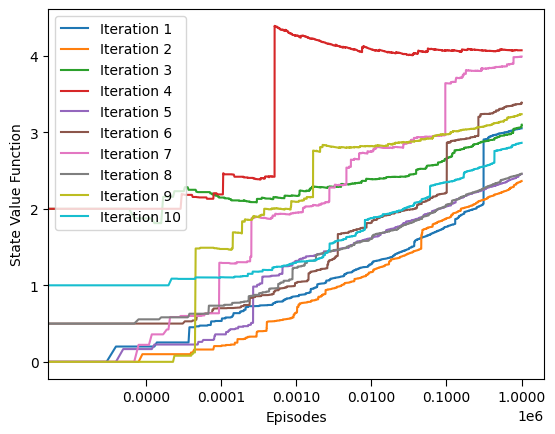

In [6]:
# Start the Monte Carlo simulation process
run_simulation()

# 2: Blackjack 

In [67]:
# test code for using the "Blackjack" implementation from OpenAI
env = gym.make("Blackjack-v1")
env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    action = env.action_space.sample()
    
    # interact with the envrionment
    next_s, reward, done, info, _ = env.step(action)
    
    # print info
    print(f"t = {t}, next_state = {next_s}, reward = {reward}, done = {done}")
    
    # check termination
    if done:
        env.reset()

t = 0, next_state = (14, 10, 0), reward = -1.0, done = True
t = 1, next_state = (19, 10, 0), reward = 1.0, done = True
t = 2, next_state = (20, 7, 1), reward = 1.0, done = True
t = 3, next_state = (9, 10, 0), reward = -1.0, done = True
t = 4, next_state = (18, 3, 1), reward = -1.0, done = True
t = 5, next_state = (18, 4, 0), reward = 1.0, done = True
t = 6, next_state = (16, 6, 0), reward = 1.0, done = True
t = 7, next_state = (15, 1, 0), reward = 0.0, done = False
t = 8, next_state = (15, 1, 0), reward = -1.0, done = True
t = 9, next_state = (24, 2, 0), reward = -1.0, done = True


## (a): Implemented first-visit Monte-Carlo policy evaluation (See pseudocode in 5.1). 

Please refer to Example 5.1, Figure 1 is reproduced here. The policy which is evaluated is the "sticks only on 20 or 21". The plots are reproduced after 500, 000 episodes (Usable ace and No usable ace). 

Completed 500/500000 episodes
Completed 1000/500000 episodes
Completed 1500/500000 episodes
Completed 2000/500000 episodes
Completed 2500/500000 episodes
Completed 3000/500000 episodes
Completed 3500/500000 episodes
Completed 4000/500000 episodes
Completed 4500/500000 episodes
Completed 5000/500000 episodes
Completed 5500/500000 episodes
Completed 6000/500000 episodes
Completed 6500/500000 episodes
Completed 7000/500000 episodes
Completed 7500/500000 episodes
Completed 8000/500000 episodes
Completed 8500/500000 episodes
Completed 9000/500000 episodes
Completed 9500/500000 episodes
Completed 10000/500000 episodes
Completed 10500/500000 episodes
Completed 11000/500000 episodes
Completed 11500/500000 episodes
Completed 12000/500000 episodes
Completed 12500/500000 episodes
Completed 13000/500000 episodes
Completed 13500/500000 episodes
Completed 14000/500000 episodes
Completed 14500/500000 episodes
Completed 15000/500000 episodes
Completed 15500/500000 episodes
Completed 16000/500000 episo

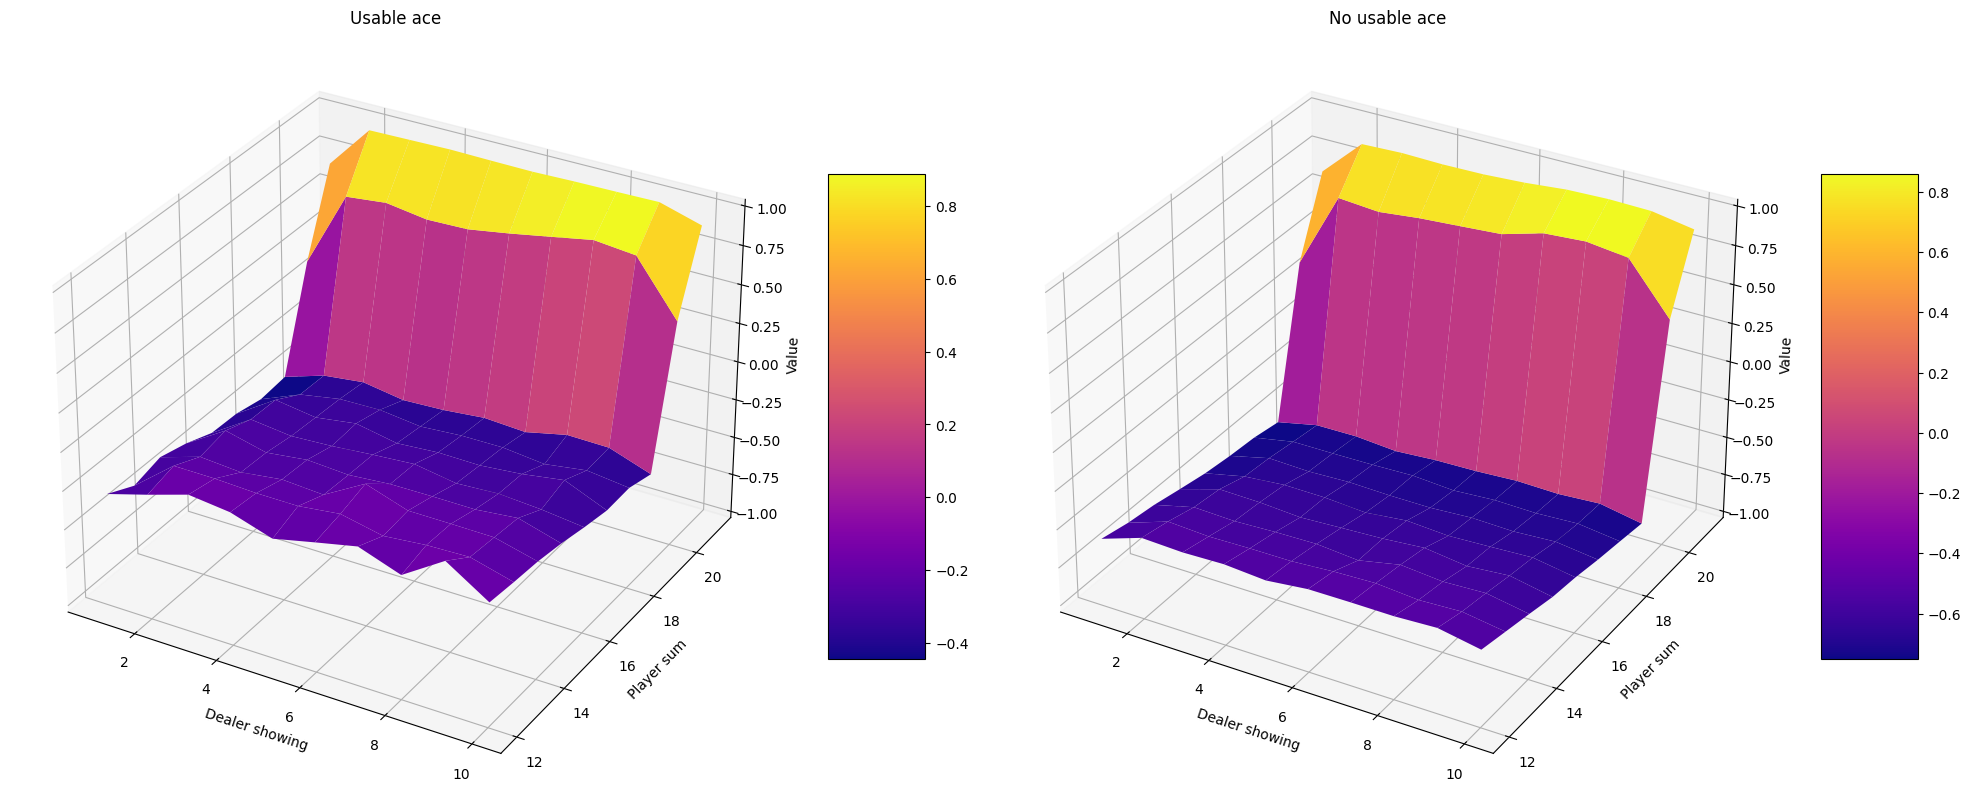

In [14]:
""" Mone Carlo Policy evaluation code"""

def monte_carlo_policy_evaluation(env, num_episodes=500000, gamma=1.0):
    # Initialize value function
    V = {}
    returns_sum = {}
    returns_count = {}

    def policy(state):
        return 0 if state[0] >= 20 else 1  # Stick if sum is 20 or 21, otherwise hit

    for i in range(1, num_episodes + 1):
        episode = []
        state, _ = env.reset()
        done = False

        # Generate an episode
        while not done:
            action = policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        # Update value function estimates
        states_in_episode = set()
        G = 0  # Initialize the return (reward)
        for t in reversed(range(len(episode))):  # Loop backward to calculate discounted returns
            state, _, reward = episode[t]
            G = reward + gamma * G  # Discounted sum of rewards
            if state not in states_in_episode:
                states_in_episode.add(state)
                if state not in returns_sum:
                    returns_sum[state] = 0
                    returns_count[state] = 0
                returns_sum[state] += G  # Update returns with discounted return
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]

        # Print completion status every 500 episodes
        if i % 500 == 0:
            print(f"Completed {i}/{num_episodes} episodes")

    return V

# Run Monte Carlo policy evaluation with gamma
env = gym.make("Blackjack-v1")
V = monte_carlo_policy_evaluation(env, gamma=0.9)  # Example: setting gamma = 0.9 for discounting

# Prepare data for plotting
player_sum = np.arange(12, 22)
dealer_showing = np.arange(1, 11)
usable_ace = np.array([False, True])

Z = np.zeros((len(player_sum), len(dealer_showing), len(usable_ace)))

for i, sum_value in enumerate(player_sum):  # Avoid using 'sum' as variable
    for j, dealer in enumerate(dealer_showing):
        for k, ace in enumerate(usable_ace):
            state = (sum_value, dealer, ace)
            Z[i, j, k] = V.get(state, 0)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})

X, Y = np.meshgrid(dealer_showing, player_sum)

# Plot for usable ace
surf1 = ax1.plot_surface(X, Y, Z[:,:,1], cmap=plt.cm.plasma)
ax1.set_title('Usable ace')
ax1.set_xlabel('Dealer showing')
ax1.set_ylabel('Player sum')
ax1.set_zlabel('Value')
ax1.set_zlim(-1, 1)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Plot for no usable ace
surf2 = ax2.plot_surface(X, Y, Z[:,:,0], cmap=plt.cm.plasma)
ax2.set_title('No usable ace')
ax2.set_xlabel('Dealer showing')
ax2.set_ylabel('Player sum')
ax2.set_zlabel('Value')
ax2.set_zlim(-1, 1)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


## (b): Implemented the first-visit Monte-Carlo control with exploring starts (Monte-Carlo ES in 5.3). 

Please refer to the Example 5.1, Figure 5.2 is reproduced here.

Episode 0
Episode 5000
Episode 10000
Episode 15000
Episode 20000
Episode 25000
Episode 30000
Episode 35000
Episode 40000
Episode 45000
Episode 50000
Episode 55000
Episode 60000
Episode 65000
Episode 70000
Episode 75000
Episode 80000
Episode 85000
Episode 90000
Episode 95000
Episode 100000
Episode 105000
Episode 110000
Episode 115000
Episode 120000
Episode 125000
Episode 130000
Episode 135000
Episode 140000
Episode 145000
Episode 150000
Episode 155000
Episode 160000
Episode 165000
Episode 170000
Episode 175000
Episode 180000
Episode 185000
Episode 190000
Episode 195000
Episode 200000
Episode 205000
Episode 210000
Episode 215000
Episode 220000
Episode 225000
Episode 230000
Episode 235000
Episode 240000
Episode 245000
Episode 250000
Episode 255000
Episode 260000
Episode 265000
Episode 270000
Episode 275000
Episode 280000
Episode 285000
Episode 290000
Episode 295000
Episode 300000
Episode 305000
Episode 310000
Episode 315000
Episode 320000
Episode 325000
Episode 330000
Episode 335000
Episo

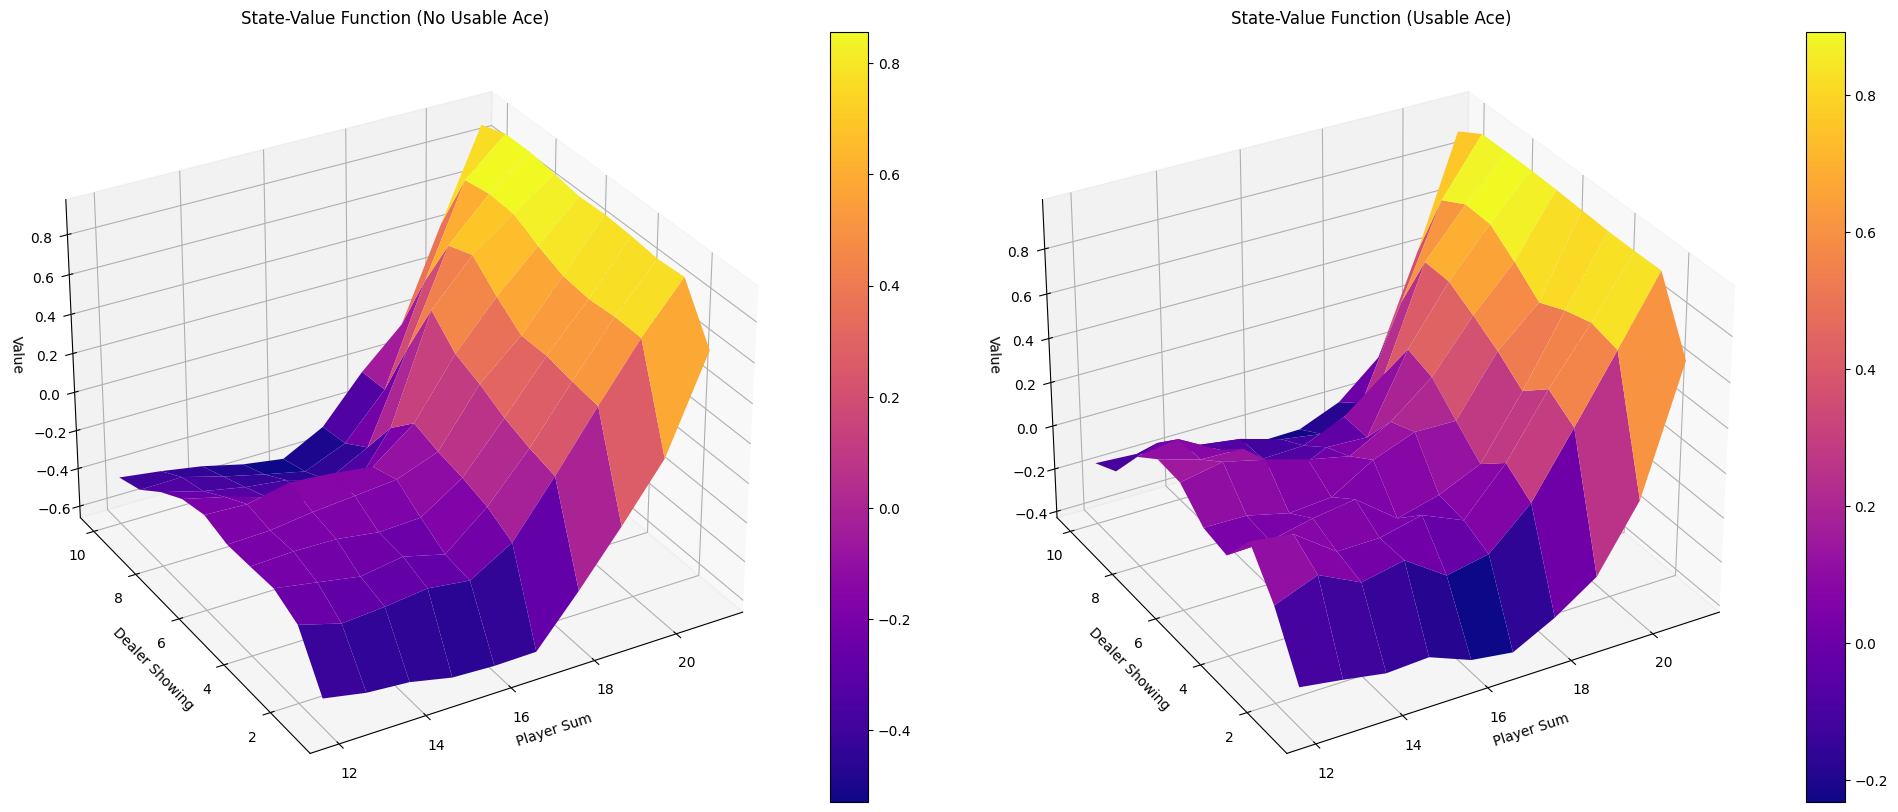

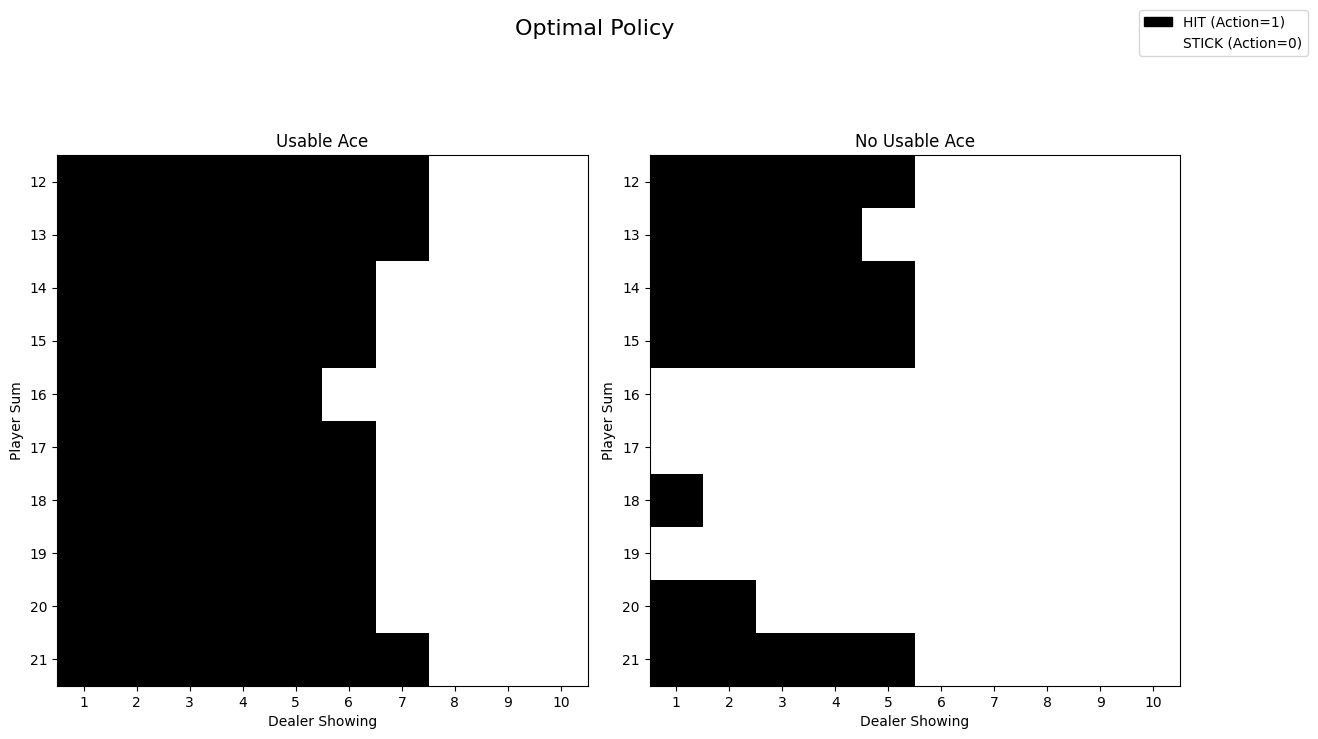

In [64]:
def monte_carlo_es(env, num_episodes=500000, gamma=1.0):
    # Initialize policy and Q-value function
    Q = {}
    policy = {}
    returns = {}

    def get_state(observation):
        # Unpack the observation tuple
        player_sum, dealer_card, usable_ace = observation
        return (player_sum, dealer_card, int(usable_ace))

    for i in range(num_episodes):
        if i % 5000 == 0:
            print(f"Episode {i}")

        # Generate an episode using exploring starts
        episode = []
        observation, _ = env.reset()  # Unpack observation and info
        state = get_state(observation)
        
        # Ensure exploring starts for actions
        action = env.action_space.sample()
        
        while True:
            next_observation, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            if terminated or truncated:
                break
            state = get_state(next_observation)
            action = policy.get(state, env.action_space.sample())

        # Update Q-values and policy
        G = 0
        visited_state_actions = set()
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward
            
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))
                if state not in returns:
                    returns[state] = {0: [], 1: []}
                returns[state][action].append(G)
                Q[state] = Q.get(state, {0: 0, 1: 0})
                Q[state][action] = np.mean(returns[state][action])
                policy[state] = max(Q[state], key=Q[state].get)

    return Q, policy

def plot_value_function(Q):
    def get_value(x, y, usable_ace):
        return max(Q.get((x, y, usable_ace), {0: 0, 1: 0}).values())

    x = range(12, 22)
    y = range(1, 11)
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(20, 8))

    for i, usable_ace in enumerate([False, True]):
        Z = np.array([[get_value(x, y, usable_ace) for x in range(12, 22)] for y in range(1, 11)])

        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.plasma)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.view_init(ax.elev, -120)
        ax.set_title(f"State-Value Function ({'Usable' if usable_ace else 'No Usable'} Ace)")
        fig.colorbar(surf, ax=ax)

    plt.tight_layout()
    plt.show()

def plot_policy(policy):
    def get_action(x, y, usable_ace):
        return policy.get((x, y, usable_ace), 0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    for ax, usable_ace, title in zip([ax1, ax2], [True, False], ['Usable Ace', 'No Usable Ace']):
        Y, X = np.meshgrid(range(12, 22), range(1, 11))
        Z = np.array([[get_action(x, y, usable_ace) for x in range(12, 22)] for y in range(1, 11)])
        
        # Use binary color map or black and white color scheme for HIT/STICK distinction
        im = ax.imshow(Z, cmap=plt.cm.binary, extent=[0.5, 10.5, 11.5, 21.5])
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_title(title)
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))
        ax.invert_yaxis()

    fig.suptitle("Optimal Policy", fontsize=16)

    # Create a custom legend to represent HIT and STICK
    hit_patch = mpatches.Patch(color='black', label='HIT (Action=1)')
    stick_patch = mpatches.Patch(color='white', label='STICK (Action=0)')
    fig.legend(handles=[hit_patch, stick_patch], loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()


# Run Monte Carlo ES
env = gym.make('Blackjack-v1')
Q, policy = monte_carlo_es(env)

# Plot results
plot_value_function(Q)
plot_policy(policy)

# 3: Four Rooms

In [3]:
"""Environment Class defined"""
class FourRooms(object):
    def __init__(self):
        # define the four room as a 2-D array for easy state space reference and visualization
        # 0 represents an empty cell; 1 represents a wall cell
        self.four_room_space = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # find the positions for all empty cells
        # note that: the origin for a 2-D numpy array is located at top-left while the origin for the FourRooms is at
        # the bottom-left. The following codes performs the re-projection.
        empty_cells = np.where(self.four_room_space == 0.0)
        self.state_space = [[col, 10 - row] for row, col in zip(empty_cells[0], empty_cells[1])]

        # define the action space
        self.action_space = {'LEFT': np.array([-1, 0]),
                             'RIGHT': np.array([1, 0]),
                             'DOWN': np.array([0, -1]),
                             'UP': np.array([0, 1])}

        # define the start state
        self.start_state = [0, 0]

        # define the goal state
        self.goal_state = [10, 10]

        # maximal time steps
        self.max_time_steps = 459

        # track the time step
        self.t = 0

    def reset(self):
        """
        Reset the agent's state to the start state [0, 0]
        Return both the start state and reward
        """
        # reset the agent state to be [0, 0]
        state = self.start_state
        # reset the reward to be 0
        reward = 0
        # reset the termination flag
        done = False
        # reset the time step tracker
        self.t = 0
        return state, reward, done

    def step(self, state, act):
        """
        Args:
            state: a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act: a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state: a list variable containing x, y integer coordinates (i.e., [1, 1])
            reward: an integer. it can be either 0 or 1.
        """
        # Increase the time step
        self.t += 1

        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if act == "LEFT" or act == "RIGHT":
                act = np.random.choice(["UP", "DOWN"], 1)[0]
            else:
                act = np.random.choice(["RIGHT", "LEFT"], 1)[0]

        # Compute the next state
        next_state = self.take_action(state, act)

        # Compute the reward
        reward = 1.0 if next_state == [10, 10] else 0.0

        # Check the termination
        # If the agent reaches the goal, reward = 1, done = True
        # If the time steps reaches the maximal number, reward = 0, done = True.
        if next_state == [10, 10] or self.t == self.max_time_steps:
            done = True
        else:
            done = False

        return next_state, reward, done

    def take_action(self, state, act):
        """
        Input args:
            state (list): a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act (string): a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state (list): a list variable containing x, y integer coordinates (i.e., [1, 1])
        """
        state = np.array(state)
        next_state = state + self.action_space[act]
        return next_state.tolist() if next_state.tolist() in self.state_space else state.tolist()

## (a): Implementation of first-visit Monte-Carlo control with a epsilon-greedy policy

In [4]:
""" First Visit Monte - Carlo Implementation """
# Implementation of the one-policy first-vist Monte-Carlo control (for ε-soft policies).
# To debug the code, we can use run_num = 5 and episode_num = 1e3
# To report the finial results, we have usedrun_num = 10 and episode_num = 1e4 

def findIndex(stateLs):
    """
    Maps each state in the list of visited states to the first occurrence index during an episode.
    This helps track where each state was first encountered for first-visit Monte Carlo updates.
    """
    stateDic = {}
    length = len(stateLs)
    for i in range(length):
        state = tuple(stateLs[-i-1])  # Convert the state to a tuple for consistency
        stateDic[state] = length - i - 1
    return stateDic

def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Plots learning curves with confidence intervals (standard error) for multiple trials.
    
    Args:
        arr_list: List of arrays containing return data from multiple trials.
        legend_list: List of legend labels corresponding to each array.
        color_list: List of colors to use for each plot.
        ylabel: Label for the Y-axis.
    """
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episodes")
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Plot the mean and 95% confidence interval (CI) for each set of returns
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        arr_err = 1.96 * arr_err  # 95% CI
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3, color=color)
        h_list.append(h)
    
    # Plot a target line for reference (e.g., target discounted return)
    ax.hlines(pow(0.99, 20), 0, arr.shape[1]-1, color='black', linestyles='dashed', label='Target')
    ax.legend(handles=h_list)
    plt.show()

class MonteCarloControl():
    def __init__(self):
        """
        Initializes the Monte Carlo control agent, setting up the environment,
        action space, action mapping (policy), and Q-value mapping.
        """
        self.env = FourRooms()  # Initialize environment
        self.aSpace = ['LEFT', 'RIGHT', 'UP', 'DOWN']  # Define action space
        # Initialize action map (policy) and Q-values for each state
        self.aMap = {tuple(state): random.choice(self.aSpace) for state in self.env.state_space}
        self.aCount = {tuple(state): {'LEFT': 0, 'RIGHT': 0, 'UP': 0, 'DOWN': 0} for state in self.env.state_space}
        self.qMap = {tuple(state): {'LEFT': 0, 'RIGHT': 0, 'UP': 0, 'DOWN': 0} for state in self.env.state_space}

    def oneEpsCtrl(self, epsilon=0, timeout=800):
        """
        Runs a single episode using the current policy with an option for epsilon-greedy exploration.
        
        Args:
            epsilon: Exploration rate for epsilon-greedy behavior.
            timeout: Maximum number of steps per episode.
        
        Returns:
            stateLs: List of visited states.
            actLs: List of actions taken.
            reward: The final reward received in the episode.
        """
        state, _, done = self.env.reset()  # Reset environment and get the initial state
        stateLs = [state]  # Store visited states
        actLs = []  # Store actions taken
        for _ in range(timeout):  # Limit episode to a maximum number of steps
            if done:
                break
            # Choose action either randomly (explore) or according to the current policy (exploit)
            coin = random.random()
            act = random.choice(self.aSpace) if coin < epsilon else self.aMap[tuple(state)]
            next_state, reward, done = self.env.step(state, act)  # Take a step in the environment
            stateLs.append(next_state)  # Record the next state
            actLs.append(act)  # Record the action taken
            state = next_state  # Move to the next state
        return stateLs, actLs, reward

    def monteCarloControl(self, eps=10000, gamma=0.99, epsilon=0):
        """
        Runs the Monte Carlo control algorithm over a given number of episodes.
        
        Args:
            eps: Number of episodes to run.
            gamma: Discount factor for future rewards.
            epsilon: Exploration rate for epsilon-greedy policy.
        
        Returns:
            rewardLs: List of discounted returns (G) for each episode.
        """
        rewardLs = []  # Store discounted return (G) for each episode
        for episode in trange(int(eps), desc="Episodes"):
            # Run a single episode and get state-action sequence and final reward
            stateLs, actLs, reward = self.oneEpsCtrl(epsilon=epsilon)
            rewardLs.append((pow(reward * gamma, len(stateLs) - 1)))  # Compute the discounted return (G)
            stateDic = findIndex(stateLs)  # Find the first occurrence of each state in the episode
            
            # Update Q-values using first-visit Monte Carlo method
            for state, index in stateDic.items():
                if index >= len(actLs):  # Ensure the index doesn't exceed action list length
                    continue
                
                # Calculate the discounted reward from the current step onward
                rewardi = pow(reward * 0.99, len(stateLs) - index - 1)
                act = actLs[index]
                # Increment visit count and update Q-value for the state-action pair
                self.aCount[state][act] += 1
                self.qMap[state][act] += (rewardi - self.qMap[state][act]) / self.aCount[state][act]
                
                # Update the policy to be greedy with respect to the updated Q-values
                maxq = max(self.qMap[state].values())
                maxa = [a for a in self.aSpace if self.qMap[state][a] == maxq]
                self.aMap[state] = random.choice(maxa)  # Break ties randomly among actions with max Q-value
                
        return rewardLs

Episodes: 100%|██████████| 10000/10000 [00:13<00:00, 731.68it/s]


<Figure size 640x480 with 0 Axes>

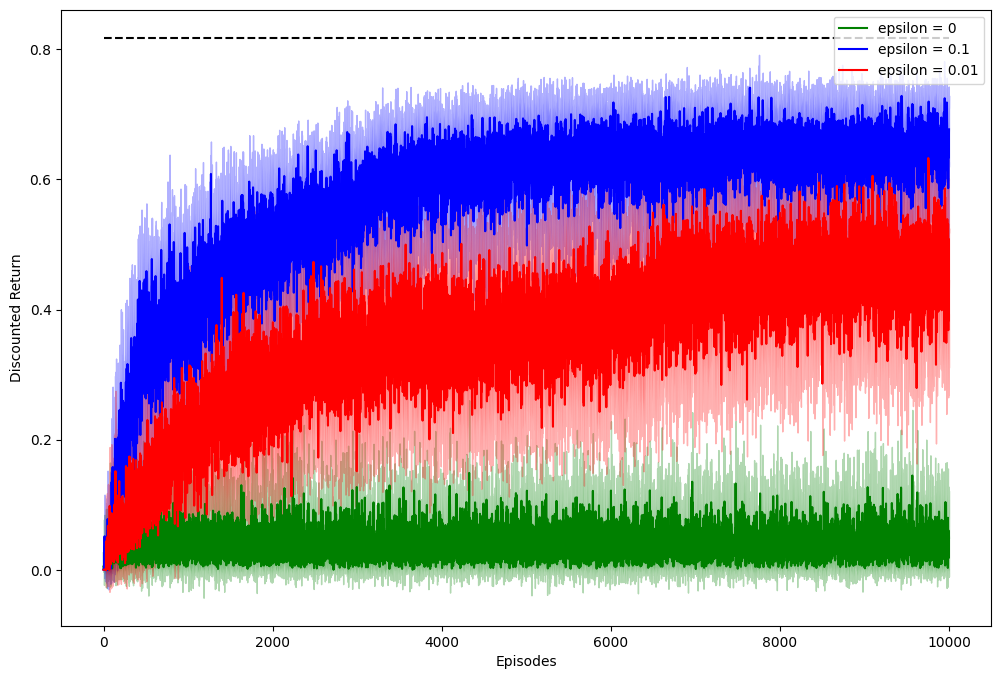

In [5]:
results = {}  # Dictionary to store results for different epsilon values
epsilon_values = [0, 0.1, 0.01]  # List of epsilon values to test
colors = {0: 'green', 0.1: 'blue', 0.01: 'red'}  # Color mapping for plot

arr_list = []  # List to hold arrays of returns for each epsilon
legend_list = []  # List to hold legend labels for each epsilon
color_list = []  # List to hold colors for each epsilon

# Loop over the different epsilon values
for epsilon in epsilon_values:
    tenIterations = []  # List to hold return results from 10 iterations
    
    # Run Monte Carlo control for 10 iterations with the current epsilon
    for _ in range(10):
        mc = MonteCarloControl()  # Create a new instance of Monte Carlo control
        rLs = mc.monteCarloControl(epsilon=epsilon)  # Run the control and get returns
        tenIterations.append(rLs)  # Append the returns to the list
    
    # Convert list of iterations into a numpy array for easier manipulation
    tenIterations = np.array(tenIterations)
    
    # Append results to the lists for plotting
    arr_list.append(tenIterations)
    legend_list.append(f'epsilon = {epsilon}')  # Add legend for the current epsilon
    color_list.append(colors[epsilon])  # Add corresponding color for the current epsilon

# Plot the results with the appropriate labels, colors, and y-axis label
plot_curves(arr_list, legend_list, color_list, ylabel='Discounted Return')

## 4: Racetrack

In [3]:
# Define the Racetrack domain 1
racetrack_v1_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]])

racetrack_v2_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

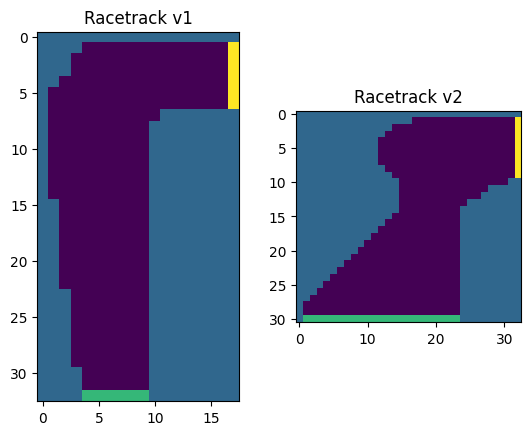

In [4]:
fig, arr = plt.subplots(1, 2)
arr[0].set_title("Racetrack v1")
arr[0].imshow(racetrack_v1_arr)
arr[1].set_title("Racetrack v2")
arr[1].imshow(racetrack_v2_arr)
plt.show()

In [5]:
"""Implementation of the Racetrack environment."""
class Racetrack(object):
    def __init__(self, version):
        # Load the pre-defined the domain having the following representation
        #   - 1: track cell
        #   - 0: empty cell
        #   - 2: empty cell on the start line
        #   - 3: empty cell on the finish line
        if version == "v1":
            self.domain_arr = racetrack_v1_arr.copy()
        else:
            self.domain_arr = racetrack_v2_arr.copy()

        # domain size
        self.height, self.width = self.domain_arr.shape

        # State space consists of:  
        # Agent location
        self.empty_cell_locs = self.render_cell_locations(val=0.0)
        self.track_cell_locs = self.render_cell_locations(val=1.0)
        self.start_cell_locs = self.render_cell_locations(val=2.0)          
        self.finish_cell_locs = self.render_cell_locations(val=3.0)

        # Action space
        self.action_space = [[-1, -1], [-1, 0], [-1, 1],
                             [0, -1], [0, 0], [0, 1],
                             [1, -1], [1, 0], [1, 1]]

        # construct the state space
        self.state_space = []
        for loc in self.start_cell_locs + self.empty_cell_locs + self.finish_cell_locs:
            for i in range(5):
                for j in range(5):
                    self.state_space.append(loc + [i, j])

        # track the agent's location
        self.state = None
        self.action = None
        self.t = None

    def reset(self):
        # randomly select one cell from the start line
        start_loc = random.sample(self.start_cell_locs, 1)[0]
        # reset the velocity to be zero for both x and y directions
        start_vel = [0, 0]
        # the state is a combination of location and velocity
        # for example: [loc_x, loc_y, vel_x, vel_y]
        state = start_loc + start_vel
        # reward
        reward = None
        # done
        done = False
        # track agent's location
        self.state = tuple(state)
        self.t = 0
        return state, reward, done

    def step(self, state, action):
        """
        Args:
            state (list): a list variable consists of agent's location + agent's current velocity. e.g., [x, y, v_x, v_y]
            action (list): a list variable consists of agent's velocity increments. e.g., [increments_v_x, increments_v_y]
        """
        # reward is -1 for every time step until the agent passes the finish line
        reward = -1
        self.t += 1
        
        # with the probability = 0.1, set action = [0, 0]
        if np.random.random() < 0.1:
            action = [0, 0]

        # update the velocity components
        # note that, both velocity is discrete and constraint within [0, 4]
        next_vel_x = np.clip(state[2] + action[0], a_min=0, a_max=4)
        next_vel_y = np.clip(state[3] + action[1], a_min=0, a_max=4)
        next_state_vel = [next_vel_x, next_vel_y]

        # only the cells on the start line can have both 0 velocities
        if next_state_vel == [0, 0]:
            if state not in self.start_cell_locs:
                # non-zero for velocities
                if state[2] == 0 and state[3] != 0:
                    next_state_vel = [0, 1]
                if state[2] != 0 and state[3] == 0:
                    next_state_vel = [1, 0]
                if state[2] != 0 and state[3] != 0:
                    non_zero_idx = random.sample([0, 1], 1)[0]
                    next_state_vel[non_zero_idx] = 1

        # update the next state location based on the updated velocities
        next_state_loc = [np.clip(state[0] + next_state_vel[0], a_min=0, a_max=self.width-1),
                          np.clip(state[1] + next_state_vel[1], a_min=0, a_max=self.height-1)]

        # check whether the agent hits the track
        if next_state_loc in self.track_cell_locs:
            # move back to the start line
            next_state_loc = random.sample(self.start_cell_locs, 1)[0]
            # reduce velocity to be 0s
            next_state_vel = [0, 0]
            # episode continue
            done = False
            # next state
            next_state = next_state_loc + next_state_vel
            return next_state, reward, done

        # check whether the agent pass the finish line
        if next_state_loc in self.finish_cell_locs:
            next_state = next_state_loc + next_state_vel
            done = True
            return next_state, 0, done

        # otherwise combine the next state
        next_state = next_state_loc + next_state_vel
        # termination
        done = False

        # track the agent's state
        self.state = tuple(next_state)
        self.action = action
        return next_state, reward, done

    def render_cell_locations(self, val):
        row_loc_indices, col_loc_indices = np.where(self.domain_arr == val)
        cell_locations = [[c, (self.height-1) - r] for r, c in zip(row_loc_indices, col_loc_indices)]
        return cell_locations

    def render(self):
        plt.clf()
        plt.title(f"s = {self.state}, a = {self.action}")
        plot_arr = self.domain_arr.copy()
        plot_arr[(self.height - 1) - self.state[1], self.state[0]] = 4
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.01)

## (a): Implementation of first-visit Monte-Carlo control with a epsilon-greedy policy (epsilon = 0.1)

In [5]:
""" First Visit Monte Carlo with epsilon-greedy policy """
# Implemented the class here and using the plotting function from one of the previous cells to plot the learning curve 
class MonteCarloControl:
    def __init__(self, env, epsilon=0.1, gamma=0.99):
        """
        Initialize Monte Carlo control with epsilon-greedy exploration and discount factor gamma.
        
        Args:
            env: The environment in which the agent interacts.
            epsilon: The exploration rate for epsilon-greedy policy.
            gamma: The discount factor for future rewards.
        """
        self.env = env  # The environment
        self.epsilon = epsilon  # Probability of choosing a random action
        self.gamma = gamma  # Discount factor for rewards
        # Q-table (state-action value function), initialized to 0
        self.Q = defaultdict(lambda: defaultdict(float))
        # List to store returns for each (state, action) pair, used for averaging
        self.returns = defaultdict(lambda: defaultdict(list))
        # Policy: for each state, an action probability distribution
        self.policy = defaultdict(lambda: [1/len(env.action_space)] * len(env.action_space))

    def choose_action(self, state):
        """
        Choose an action based on epsilon-greedy policy for a given state.
        
        Args:
            state: The current state of the environment.
        
        Returns:
            The action index selected according to epsilon-greedy strategy.
        """
        if random.random() < self.epsilon:
            # Explore: choose a random action
            return random.choice(range(len(self.env.action_space)))
        else:
            # Exploit: choose the action with the highest Q-value
            return max(range(len(self.env.action_space)), key=lambda a: self.Q[state][a])

    def update_policy(self, state):
        """
        Update the policy for a given state by making the best action more likely (greedy).
        
        Args:
            state: The state for which to update the policy.
        """
        # Find the action with the highest Q-value (best action)
        best_action = max(range(len(self.env.action_space)), key=lambda a: self.Q[state][a])
        # Update policy: epsilon-greedy distribution
        for a in range(len(self.env.action_space)):
            # Probability for all actions: explore or exploit (give more weight to the best action)
            self.policy[state][a] = self.epsilon / len(self.env.action_space) + (1 - self.epsilon) * (a == best_action)

    def run_episode(self):
        """
        Run a single episode by interacting with the environment and store the episode history.
        
        Returns:
            A list of tuples representing (state, action, reward) for each step in the episode.
        """
        state, _, done = self.env.reset()  # Initialize environment and get the initial state
        episode = []  # List to store the sequence of (state, action, reward)
        while not done:
            # Choose an action based on the current policy
            action_idx = self.choose_action(tuple(state))
            action = self.env.action_space[action_idx]
            # Step in the environment using the chosen action
            next_state, reward, done = self.env.step(state, action)
            # Store the (state, action, reward) for this step
            episode.append((tuple(state), action_idx, reward))
            # Move to the next state
            state = next_state
        return episode

    def train(self, num_episodes):
        """
        Train the agent using Monte Carlo Control with epsilon-greedy policy over multiple episodes.
        
        Args:
            num_episodes: The number of episodes to train for.
        
        Returns:
            A list of total returns (G) for each episode.
        """
        episode_returns = []  # Store the return (total reward) for each episode
        pbar = tqdm(total=num_episodes, desc="Episodes", leave=False)  # Progress bar
        for episode in range(1, num_episodes + 1):
            episode_data = self.run_episode()  # Run an episode and get the sequence
            G = 0  # Initialize the return (G) for the episode
            # Loop backward through the episode to compute the return and update Q-values
            for t in range(len(episode_data) - 1, -1, -1):
                state, action, reward = episode_data[t]
                G = self.gamma * G + reward  # Compute return for step t
                # Check if the (state, action) pair is the first occurrence in the episode
                if (state, action) not in [(x[0], x[1]) for x in episode_data[:t]]:
                    # Store the return (G) for this (state, action) pair
                    self.returns[state][action].append(G)
                    # Update the Q-value by averaging over all returns
                    self.Q[state][action] = np.mean(self.returns[state][action])
                    # Update the policy based on the new Q-values
                    self.update_policy(state)
            episode_returns.append(G)  # Append total return for this episode
            # Update the progress bar every 50 episodes
            if episode % 50 == 0:
                pbar.update(50)
        pbar.close()  # Close the progress bar
        return episode_returns

def run_monte_carlo(env, num_trials, num_episodes):
    """
    Run multiple Monte Carlo trials and collect the returns from each trial.
    
    Args:
        env: The environment in which the agent interacts.
        num_trials: The number of trials (independent runs of Monte Carlo training).
        num_episodes: The number of episodes per trial.
    
    Returns:
        A 2D numpy array where each row represents the returns from one trial.
    """
    all_returns = []  # Store returns from each trial
    for trial in tqdm(range(1, num_trials + 1), desc="Trials"):  # Progress bar for trials
        print(f"\nTrial {trial}/{num_trials}")
        mc = MonteCarloControl(env)  # Create a new Monte Carlo Control instance
        returns = mc.train(num_episodes)  # Train the agent and get the returns for this trial
        all_returns.append(returns)  # Store the returns
    return np.array(all_returns)  # Convert to a numpy array for easier analysis

In [ ]:
# Run Monte-Carlo control on both Racetrack versions
num_trials = 10
num_episodes = 2000

print("Running Monte-Carlo control on Racetrack v1...")
env_v1 = Racetrack("v1")
returns_v1 = run_monte_carlo(env_v1, num_trials, num_episodes)

print("\nRunning Monte-Carlo control on Racetrack v2...")
env_v2 = Racetrack("v2")
returns_v2 = run_monte_carlo(env_v2, num_trials, num_episodes)

# Plot the learning curves
plt.figure(figsize=(12, 6)) 

# Plot for Racetrack v1
plt.subplot(1, 2, 1)
mean_returns_v1 = np.mean(returns_v1, axis=0)
std_returns_v1 = np.std(returns_v1, axis=0) / np.sqrt(num_trials)
plt.plot(range(num_episodes), mean_returns_v1)
plt.fill_between(range(num_episodes), 
                 mean_returns_v1 - 1.96 * std_returns_v1, 
                 mean_returns_v1 + 1.96 * std_returns_v1, 
                 alpha=0.3)
plt.title("Racetrack v1")
plt.xlabel("Episodes")
plt.ylabel("Discounted Return")

# Plot for Racetrack v2
plt.subplot(1, 2, 2)
mean_returns_v2 = np.mean(returns_v2, axis=0)
std_returns_v2 = np.std(returns_v2, axis=0) / np.sqrt(num_trials)
plt.plot(range(num_episodes), mean_returns_v2) 
plt.fill_between(range(num_episodes), 
                 mean_returns_v2 - 1.96 * std_returns_v2, 
                 mean_returns_v2 + 1.96 * std_returns_v2, 
                 alpha=0.3)
plt.title("Racetrack v2")
plt.xlabel("Episodes")
plt.ylabel("Discounted Return") 

plt.tight_layout()
plt.show()

# Use the provided plot_curves function
plot_curves([returns_v1, returns_v2], 
            ["Racetrack v1", "Racetrack v2"], 
            ["blue", "red"], 
            "Discounted Return")

Running Monte-Carlo control on Racetrack v1...
Trials:   0%|          | 0/10 [00:00<?, ?it/s]
Trial 1/10

Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]Trials:  10%|█         | 1/10 [00:59<08:54, 59.38s/it]
Trial 2/10
Trials:  20%|██        | 2/10 [06:04<27:11, 203.91s/it]
Trial 3/10
Trials:  30%|███       | 3/10 [21:08<1:01:06, 523.73s/it]
Trial 4/10
Trials:  40%|████      | 4/10 [24:04<38:37, 386.17s/it]  
Trial 5/10
Trials:  50%|█████     | 5/10 [28:57<29:23, 352.77s/it]
Trial 6/10
Trials:  60%|██████    | 6/10 [1:51:27<2:07:42, 1915.64s/it]
Trial 7/10
Trials:  70%|███████   | 7/10 [1:55:44<1:08:41, 1373.67s/it]
Trial 8/10
Trials:  80%|████████  | 8/10 [2:08:19<39:13, 1176.53s/it]  
Trial 9/10
Trials:  90%|█████████ | 9/10 [2:14:50<15:31, 931.01s/it] 
Trial 10/10
Trials: 100%|██████████| 10/10 [2:35:57<00:00, 935.77s/it] 

Running Monte-Carlo control on Racetrack v2...
Trials:   0%|          | 0/10 [00:00<?, ?it/s]
Trial 1/10
Trials:  10%|█         | 1/10 [00:53<08:05, 53.89s/it

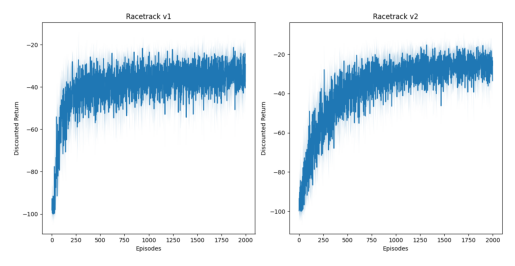

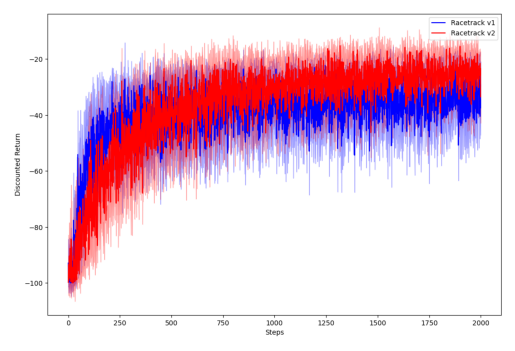

In [4]:
# I HAVE EXECUTED THE ABOVE CODE IN A SEPERATE .PY FILE ON MY SYSTEM AND SAVED THE OUTPUT IN TEXT FILE AND IMAGES. 
# I WILL LOAD THE TEXT DOCUMENT AND IMAGES HERE TO DISPLAY THE OUTPUT. 
# THE CODE WAS TAKING TOO LONG TO RUN. 

# Load and display the text content
text_data = open('text.txt', 'r').read()
print(text_data)  # Display the text content

# Load and display the images
output30_img = Image.open('output30.png')
output31_img = Image.open('output31.png')

# Display the first image
plt.figure()
plt.imshow(output30_img)
plt.axis('off')  # Hide axis
plt.show()

# Display the second image
plt.figure()
plt.imshow(output31_img)
plt.axis('off')  # Hide axis
plt.show()

## (b): Implementation of off-policy Monte-Carlo control.

In [ ]:
""" OFF POLICY MONTE-CARLO CONTROL """
# Implemented the code here and using the plotting function from one of the previous cells to plot the learning curve 
# Precompute the state space to reduce redundant checks and speed up state initialization
def precompute_state_space(env):
    state_space = []
    for loc in env.start_cell_locs + env.empty_cell_locs + env.finish_cell_locs:
        for i in range(5):
            for j in range(5):
                state_space.append(tuple(loc + [i, j]))
    return state_space

# Initialize racetrack environment
def run_off_policy_monte_carlo_control(env_version, epsilon=0.1, trials=10, episodes=2000, gamma=0.9):
    # Initialize the environment
    env = Racetrack(version=env_version)
    
    # Precompute the state space for the racetrack to optimize access to Q-values
    state_space = precompute_state_space(env)
    
    # Initialize Q-values and cumulative weights for all states
    Q = {state: np.zeros(len(env.action_space)) for state in state_space}
    C = {state: np.zeros(len(env.action_space)) for state in state_space}

    # Function to select an action using epsilon-greedy behavior policy
    def select_action(state, epsilon):
        if np.random.rand() < epsilon:
            return random.choice(range(len(env.action_space)))  # Explore
        else:
            return np.argmax(Q[state])  # Exploit (Greedy)

    # Function to select an action using the greedy target policy
    def select_greedy_action(state):
        return np.argmax(Q[state])  # Greedy action

    # Tracking discounted returns for each episode over all trials
    discounted_returns = np.zeros((trials, episodes))

    for trial in range(trials):
        print(f"Starting trial {trial + 1} of {trials}...")
        for episode in range(episodes):
            # Reset environment for a new episode
            state, _, done = env.reset()
            episode_data = []  # To store state, action, reward for this episode

            # Generate an episode using the behavior policy (epsilon-greedy)
            while not done:
                action = select_action(tuple(state), epsilon)  # Behavior policy
                next_state, reward, done = env.step(state, env.action_space[action])
                episode_data.append((tuple(state), action, reward))
                state = next_state
            
            # Off-policy Monte Carlo Control with importance sampling
            G = 0  # Discounted return
            W = 1.0  # Importance sampling ratio
            for state, action, reward in reversed(episode_data):
                G = reward + gamma * G  # Update discounted return

                # Update cumulative sum of weights for importance sampling
                C[state][action] += W
                # Update Q(s, a) using importance sampling
                Q[state][action] += (W / C[state][action]) * (G - Q[state][action])

                # If the chosen action is not the greedy action in the target policy, stop
                if action != select_greedy_action(state):
                    break
                W = W * (1 / (1 - epsilon + epsilon / len(env.action_space)))  # Update importance sampling ratio
            
            # Track the discounted return for the target policy (using evaluation)
            state, _, done = env.reset()
            G_target = 0
            while not done:
                action = select_greedy_action(tuple(state))  # Rollout using the target policy
                next_state, reward, done = env.step(state, env.action_space[action])
                G_target += reward
                state = next_state

            discounted_returns[trial, episode] = G_target

            # Print progress for every 50 episodes
            if (episode + 1) % 50 == 0:
                print(f"  Trial {trial + 1}, Episode {episode + 1}: Completed.")
        
        # Trial completion update
        print(f"Trial {trial + 1} of {trials} completed.\n")
    
    return discounted_returns

In [ ]:
# Running for both tracks and plotting
def run_experiment_and_plot():
    # Trials and episodes setup
    trials = 2
    episodes = 500
    epsilon = 0.1
    gamma = 0.9  # Discount factor

    # Run Monte Carlo control on two racetrack versions
    results_v1 = run_off_policy_monte_carlo_control("v1", epsilon, trials, episodes, gamma)
    results_v2 = run_off_policy_monte_carlo_control("v2", epsilon, trials, episodes, gamma)
    
    # Plot the learning curves
    plot_curves(
        arr_list=[results_v1, results_v2],
        legend_list=["Track v1", "Track v2"],
        color_list=["blue", "green"],
        ylabel="Discounted Return"
    )

    # Visualize several rollouts of the optimal policy
    visualize_optimal_rollout("v1", Q)
    visualize_optimal_rollout("v2", Q)

# Visualize rollouts using the target policy
def visualize_optimal_rollout(env_version, Q):
    env = Racetrack(version=env_version)
    state, _, done = env.reset()

    plt.imshow(env.domain_arr, cmap="gray")
    plt.title(f"Optimal Policy Rollout for {env_version}")
    
    # Rollout the target policy
    while not done:
        action = np.argmax(Q[tuple(state)])  # Choose greedy action
        next_state, _, done = env.step(state, env.action_space[action])
        plt.plot(state[0], state[1], 'ro')  # Mark the agent's path
        state = next_state

    plt.show()

In [2]:
# Run the monte carlo simulation and generate the plots
run_experiment_and_plot()